Department of Physics, University of Pisa (AA 2020-2021)

### Multimessenger Physics Laboratory



## Data Analysis experience - Gravitational Waves GW170814
#### (Margherita De Toma, 17-05-2021)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import colors
from matplotlib import cm
import pylab
from astropy.io import fits
from gwosc.datasets import find_datasets
from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import sigma

In [2]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
main_dir =os.path.dirname(work_dir)
data_dir = os.path.join(main_dir,"data")
results_dir = os.path.join(main_dir,"results")

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [3]:
#explore the events in the dataset
events = find_datasets(type="event")
print(events)

['151008-v1', '151012.2-v1', '151116-v1', '161202-v1', '161217-v1', '170208-v1', '170219-v1', '170405-v1', '170412-v1', '170423-v1', '170616-v1', '170630-v1', '170705-v1', '170720-v1', '190924_232654-v1', '191223_014159-v1', '191225_215715-v1', '200114_020818-v1', '200214_224526-v1', 'GRB051103-v1', 'GW150914-v1', 'GW150914-v2', 'GW150914-v3', 'GW151012-v1', 'GW151012-v2', 'GW151012-v3', 'GW151226-v1', 'GW151226-v2', 'GW170104-v1', 'GW170104-v2', 'GW170608-v1', 'GW170608-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v1', 'GW170814-v2', 'GW170814-v3', 'GW170817-v1', 'GW170817-v2', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1', 'GW190408_181802-v1', 'GW190412-v1', 'GW190412-v2', 'GW190412-v3', 'GW190413_052954-v1', 'GW190413_134308-v1', 'GW190421_213856-v1', 'GW190424_180648-v1', 'GW190425-v1', 'GW190425-v2', 'GW190426_152155-v1', 'GW190503_185404-v1', 'GW190512_180714-v1', 'GW190513_205428-v1', 'GW190514_065416-v1', 'GW190517_055101-v1', 'GW190519_153544-v1', 'GW190521-v1', 

In [4]:
ev_name = "GW170814"

ev_gps = event_gps(ev_name)
event_urls = get_event_urls(ev_name)

print("%s,%.1f,%s" % (ev_name,ev_gps,event_urls))

GW170814,1186741861.5,['https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/H-H1_GWOSC_4KHZ_R1-1186741846-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/H-H1_GWOSC_4KHZ_R1-1186739814-4096.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/L-L1_GWOSC_4KHZ_R1-1186741846-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/L-L1_GWOSC_4KHZ_R1-1186739814-4096.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/V-V1_GWOSC_4KHZ_R1-1186741846-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/V-V1_GWOSC_4KHZ_R1-1186739814-4096.hdf5']


In [14]:
# Select a time interval of 1 hour around the event
dt_win = 3600*0.5
ev_t0_min = ev_gps - dt_win
ev_t0_max = ev_gps + dt_win
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data_H1 = TimeSeries.fetch_open_data("H1", ev_t0_min, ev_t0_max, cache=True)
data_L1 = TimeSeries.fetch_open_data("L1", ev_t0_min, ev_t0_max, cache=True)
data_V1 = TimeSeries.fetch_open_data("V1", ev_t0_min, ev_t0_max, cache=True)

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,'H1',ev_t0_min,ev_t0_max))

#get the segments in a larger time window (just to have a bigger time span to look over)
segments_H1 = DataQualityFlag.fetch_open_data("H1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)
segments_L1 = DataQualityFlag.fetch_open_data("L1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)
segments_V1 = DataQualityFlag.fetch_open_data("V1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)

Get data for GW170814 (H1) GPS: 1186740061.50 - 1186743661.50


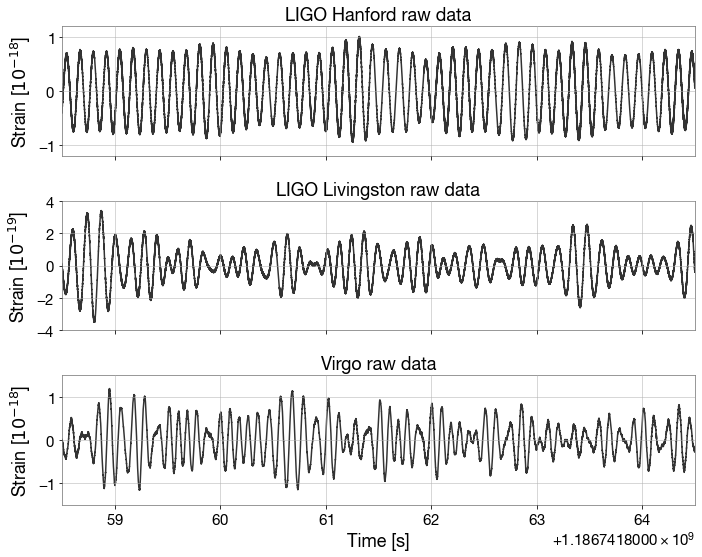

In [19]:
data = [data_H1, data_L1, data_V1]
label = ['LIGO Hanford', 'LIGO Livingstone', 'VIRGO']
ylim = [1.2, 4, 1.5]
xtext = [6.53+1.18674185e9, 6.50+1.18674185e9, 6.60+1.18674185e9]
ytext = [2e-21, 2e-21, 4]
factor = [1e18, 1e19, 1e18]

fig, axes = plt.subplots(nrows=3, figsize=(10,8), sharex=True)
plt.rcParams.update({'font.size': 15})

i = 0
for ax in axes:
    ax.plot(data[i]*factor[i], color='black', alpha=0.8)
    ax.set_xlim(ev_gps-3, ev_gps+3)
    ax.set_ylim(-ylim[i], ylim[i])
    #ax.text(xtext[i], ytext[i], label[i], fontsize=14, bbox=dict(facecolor='none', edgecolor='black', pad=8.0))
    #ax.set_xticks(np.arange(1e11, 5e11, 0.01))
    i += 1

axes[0].set_title("LIGO Hanford raw data")
axes[0].set_ylabel('Strain [$10^{-18}$]')
axes[1].set_title("LIGO Livingston raw data")
axes[1].set_ylabel('Strain [$10^{-19}$]')
axes[2].set_title("Virgo raw data")
axes[2].set_ylabel('Strain [$10^{-18}$]')
axes[2].set_xlabel("Time [s]")
plt.savefig(os.path.join(results_dir, 'raw_data.png'))
plt.tight_layout()
plt.show()

/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)
/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)
/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


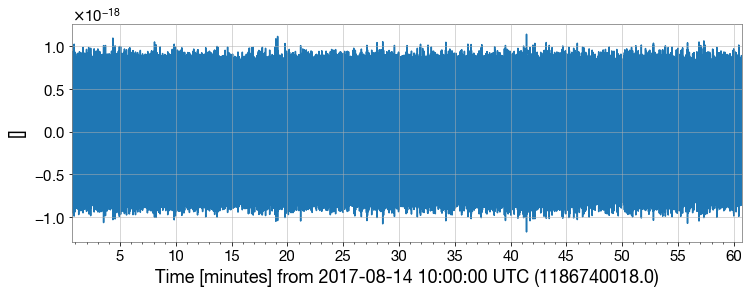

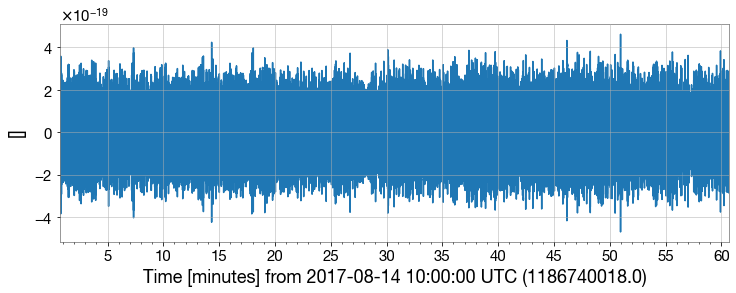

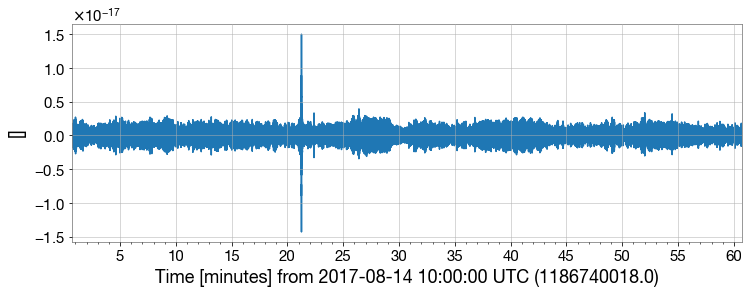

In [20]:
from gwpy.plot import Plot

#Plot raw data....   
plot_data_H1 = data_H1.plot()
plot_data_H1.show()

plot_data_L1 = data_L1.plot()
plot_data_L1.show()

plot_data_V1 = data_V1.plot()
plot_data_V1.show()

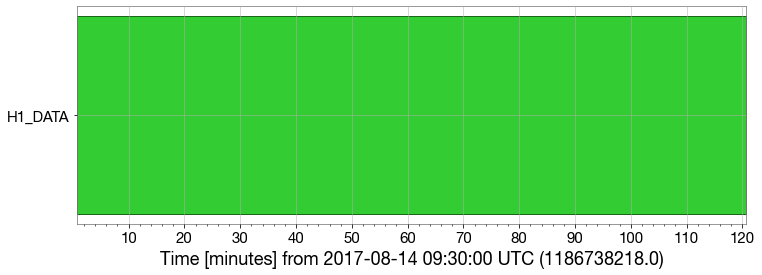

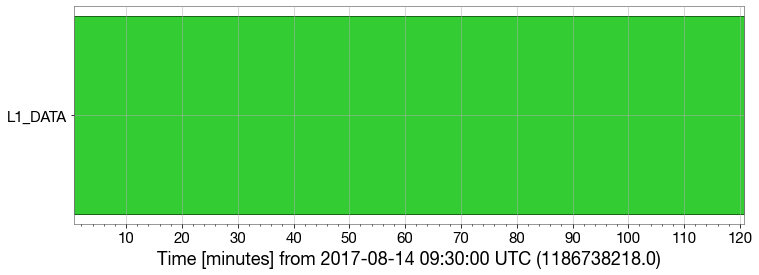

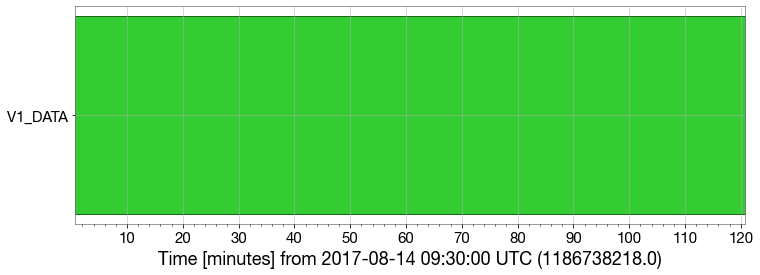

In [21]:
#..and segments. Green is data ok, red is data bad...
plot_H1 = segments_H1.plot()
plot_H1.show()

plot_L1 = segments_L1.plot()
plot_L1.show()

plot_V1 = segments_V1.plot()
plot_V1.show()

/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


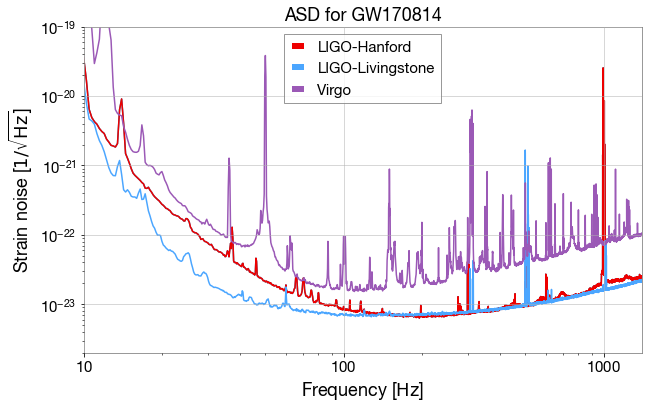

In [31]:
#Now we can plot the ASD as well, using GWPY and  the Welch method with a overlapping window of 4 seconds
asd_H1 = data_H1.asd(fftlength=4, method="median")
asd_L1 = data_L1.asd(fftlength=4, method="median")
asd_V1 = data_V1.asd(fftlength=4, method="median")

plot = asd_H1.plot(figsize=(10,6))
ax = plot.gca()

ax1 = ax.plot(asd_H1, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(asd_L1, label='LIGO-Livingstone', color='gwpy:ligo-livingston')
ax.plot(asd_V1, label='Virgo', color='gwpy:virgo')
ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-19)
ax.set_title("ASD for " + ev_name)
plt.savefig(os.path.join(results_dir, 'asd_tot.png'))
plot.show()

### Asd function

In [35]:
def make_asd(data, freq_min, freq_max, delta_freq, delta_t, factor_scale):
    dt = 0.000244140625 #s
    
    delta_time_index = int(delta_t / dt)
    interval_asd = data[0:delta_time_index].asd(method="median")
    
    # Let's find the frequency differential:
    # df * len(interval_asd) is constant, if I change interval_time_len 
    # (the index interval to select a TimeSeries piece of dt*interval_time_len seconds),
    # also len(interval_asd) will change, and df also will change
    # to mantain the product constant
    df = 2048.25 / len(interval_asd)
    delta_freq_index = int(delta_freq / df)
    i1 = int(freq_min/df)
    i2 = int(freq_max/df)

    ASD = []
    for i in range(0, len(data), delta_time_index):
        interval_asd = data[i:i+delta_time_index].asd(method="median")
        asd_mean = []
        j = i1
        while (j < i2):
            asd_mean.append(np.mean(np.array(interval_asd[j:j+delta_freq_index])))
            j += delta_freq_index
        ASD.append(np.array(asd_mean)*factor_scale)
    
    return ASD

In [36]:
freq_min = 10 #Hz
freq_max = 1000 #Hz
delta_freq = 10 #Hz
delta_time = 4 #seconds

In [37]:
ASD_H1 = make_asd(data_H1, 30, 1000, 1000, 10, 1e24)
asd_all_freq_H1 = []

for i in range(len(ASD_H1)):
    for j in range(len(ASD_H1[i])):
        asd_all_freq_H1.append(ASD_H1[i][j])
asd_all_freq_H1 = np.array(asd_all_freq_H1)


ASD_L1 = make_asd(data_L1, 30, 1000, 1000, 10, 1e24)
asd_all_freq_L1 = []

for i in range(len(ASD_L1)):
    for j in range(len(ASD_L1[i])):
        asd_all_freq_L1.append(ASD_L1[i][j])
asd_all_freq_L1 = np.array(asd_all_freq_L1)


ASD_V1 = make_asd(data_V1, 30, 1000, 1000, 10, 1e23)
asd_all_freq_V1 = []

for i in range(len(ASD_V1)):
    for j in range(len(ASD_V1[i])):
        asd_all_freq_V1.append(ASD_V1[i][j])
asd_all_freq_V1 = np.array(asd_all_freq_V1)

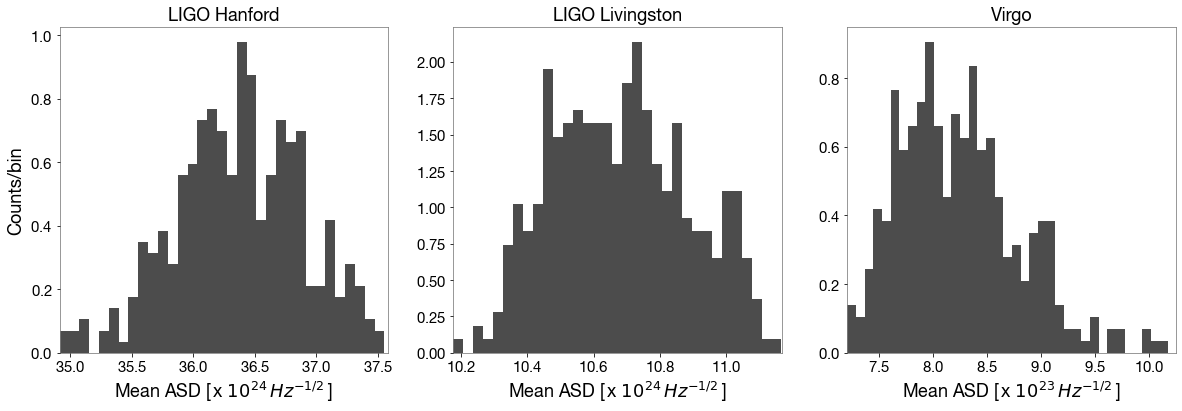

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=False)
plt.rcParams.update({'font.size': 15})

hist_H1 = ax1.hist(asd_all_freq_H1, bins=np.arange(min(asd_all_freq_H1), max(asd_all_freq_H1), 0.08), density=True, color='black', alpha=0.7)

ax1.set_xlim(min(asd_all_freq_H1), max(asd_all_freq_H1))
ax1.set_xlabel(r'Mean ASD [$\,$x $10^{24}\,Hz^{-1/2}$$\,$]')
ax1.set_ylabel('Counts/bin')
ax1.set_title('LIGO Hanford')
ax1.grid(False)

hist_L1 = ax2.hist(asd_all_freq_L1, bins=np.arange(min(asd_all_freq_L1), max(asd_all_freq_L1), 0.03), density=True, color='black', alpha=0.7)
ax2.set_xlim(min(asd_all_freq_L1), max(asd_all_freq_L1))
ax2.set_xlabel(r'Mean ASD [$\,$x $10^{24}\,Hz^{-1/2}$$\,$]')
ax2.set_title('LIGO Livingston')
ax2.grid(False)

hist_V1 = ax3.hist(asd_all_freq_V1, bins=np.arange(min(asd_all_freq_V1), max(asd_all_freq_V1), 0.08), density=True, color='black', alpha=0.7)
ax3.set_xlim(min(asd_all_freq_V1), max(asd_all_freq_V1))
ax3.set_xlabel(r'Mean ASD [$\,$x $10^{23}\,Hz^{-1/2}$$\,$]')
ax3.set_title('Virgo')
ax3.grid(False)

plt.savefig(os.path.join(results_dir, 'mean_asd_30_1000_Hz.png'))
plt.show()

In [39]:
hist_H1[1].std()/hist_H1[1].mean()*100

2.166126143989352

In [40]:
hist_L1[1].std()/hist_L1[1].mean()*100

2.7579668854876194

In [41]:
hist_V1[1].std()/hist_V1[1].mean()*100

10.093586416760973

In [42]:
ASD_H1 = make_asd(data_H1, freq_min, freq_max, 1, delta_time, 1e24)

In [43]:
ASD_L1 = make_asd(data_L1, freq_min, freq_max, 1, delta_time, 1e24)

In [44]:
ASD_V1 = make_asd(data_V1, freq_min, freq_max, 1, delta_time, 1e23)

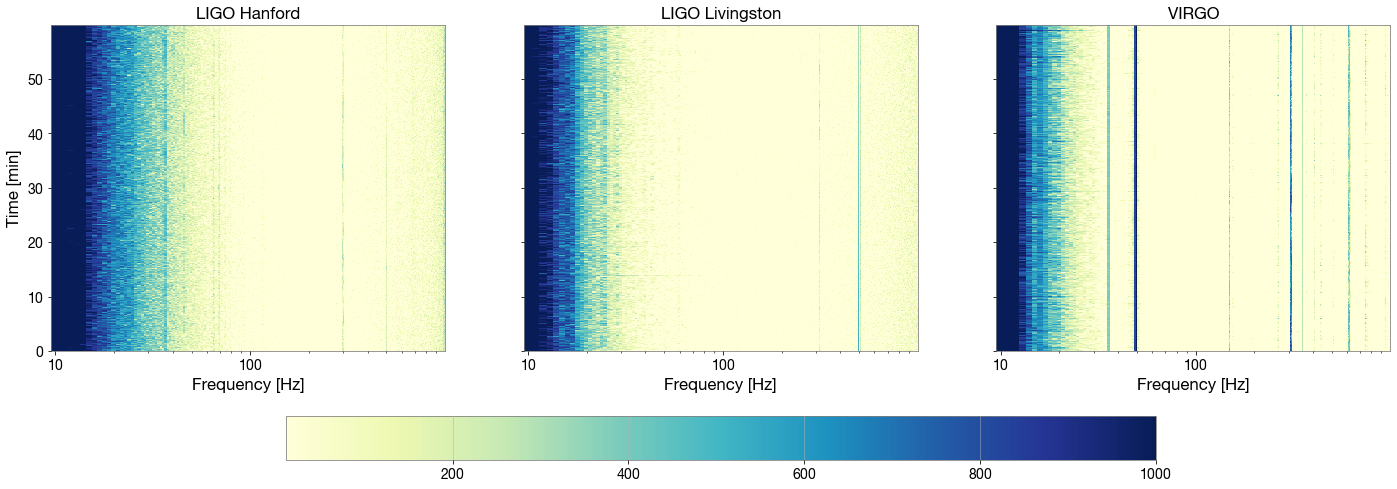

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24,8), sharex=False, sharey=True)
plt.rcParams.update({'font.size': 14})
freq = np.arange(freq_min, freq_max, 1)

time = np.arange(0, 4*len(ASD_H1), 4)/60
ax1.pcolor(freq, time, ASD_H1, shading='auto', cmap='YlGnBu', norm=LogNorm(vmin=10, vmax=10**3))
ax1.set_xscale('log')
ax1.set_yticks(np.arange(0, 60, 10))
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Time [min]')
ax1.set_title('LIGO Hanford')
#ax1.colorbar()

time = np.arange(0, 4*len(ASD_L1), 4)/60
ax2.pcolor(freq, time, ASD_L1, shading='auto', cmap='YlGnBu', norm=LogNorm(vmin=10, vmax=10**3))
ax2.set_xscale('log')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_title('LIGO Livingston')
#ax2.colorbar()

time = np.arange(0, 4*len(ASD_V1), 4)/60
ax3.pcolor(freq, time, ASD_V1, shading='auto', cmap='YlGnBu', norm=LogNorm(vmin=10, vmax=10**3))
ax3.set_xscale('log')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_title('VIRGO')

norm = colors.Normalize(vmin=10, vmax=10**3)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='YlGnBu'), ax=(ax1,ax2,ax3), orientation='horizontal', fraction=.1)

plt.savefig(os.path.join(results_dir,'asd_time_evolution.png'))
plt.show()

### Bandpass

/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


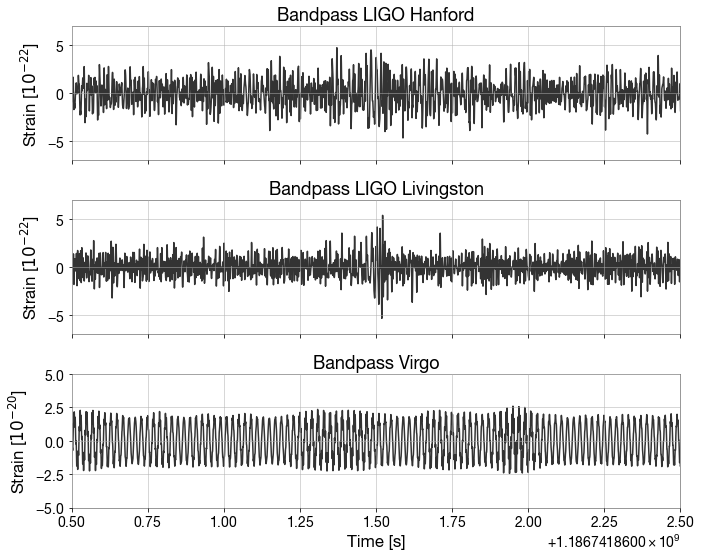

In [48]:
# We can do some bandpass and see its effect
f_min = 50
f_max = 300

data_filtered = [data_H1.bandpass(f_min, f_max).notch(60), data_L1.bandpass(f_min, f_max).notch(60), data_V1.bandpass(f_min, f_max)]
label = ['LIGO Hanford', 'LIGO Livingstone', 'VIRGO']
ylim = [7, 7, 5]
xtext = [6.53+1.18674185e9, 6.50+1.18674185e9, 6.60+1.18674185e9]
ytext = [2e-21, 2e-21, 4]
factor = [1e22, 1e22, 1e20]

fig, axes = plt.subplots(nrows=3, figsize=(10,8), sharex=True)
plt.rcParams.update({'font.size': 15})

i = 0
for ax in axes:
    ax.plot(data_filtered[i]*factor[i], color='black', alpha=0.8)
    ax.set_xlim(ev_gps-1, ev_gps+1)
    ax.set_ylim(-ylim[i], ylim[i])
    #ax.text(xtext[i], ytext[i], label[i], fontsize=14, bbox=dict(facecolor='none', edgecolor='black', pad=8.0))
    #ax.set_xticks(np.arange(1e11, 5e11, 0.01))
    i += 1

axes[0].set_title("Bandpass LIGO Hanford")
axes[0].set_ylabel('Strain [$10^{-22}$]')
axes[1].set_title("Bandpass LIGO Livingston")
axes[1].set_ylabel('Strain [$10^{-22}$]')
axes[2].set_title("Bandpass Virgo")
axes[2].set_ylabel('Strain [$10^{-20}$]')
axes[2].set_xlabel("Time [s]")
plt.savefig(os.path.join(results_dir, 'bandpass.png'))
plt.tight_layout()
plot.show()

/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


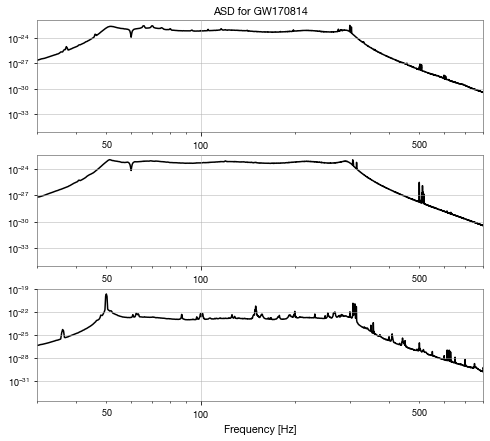

In [51]:
# one can take a look at the ASD of the filtered signal as well. This is a good double check on the filters that
# have been applied

asd_H1 = data_filtered[0].asd(fftlength=4, method="median")
asd_L1 = data_filtered[1].asd(fftlength=4, method="median")
asd_V1 = data_filtered[2].asd(fftlength=4, method="median")

data = [asd_H1, asd_L1, asd_V1]
ylim = [1e-22, 1e-22, 1e-19]
xtext = [280, 280, 320]
ytext = [5e-23, 5e-23, 6e-20]

fig, axes = plt.subplots(nrows=3, figsize=(8, 7))
plt.rcParams.update({'font.size': 9})
label = ['LIGO Hanford', 'LIGO Livingstone', 'VIRGO']

i = 0
for ax in axes:
    ax.plot(data[i], color='black')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(30,800)
    #ax.set_ylim(1e-24, ylim[i])
    #ax.text(xtext[i], ytext[i], label[i],  bbox=dict(facecolor='none', edgecolor='grey', pad=6.))
    i += 1

axes[0].set_title("ASD for " + ev_name)
axes[2].set_xlabel('Frequency [Hz]')
#plt.tight_layout()
#plt.savefig(os.path.join(results_dir,'asd.png'))
plot.show()

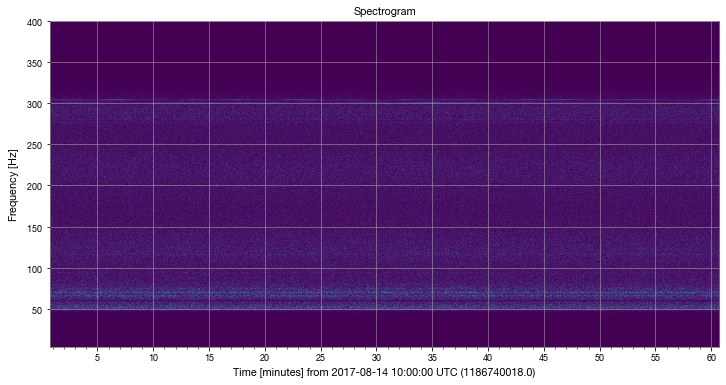

In [50]:
#now, the spectrograms
specgram = data_filtered[0].spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()
ax = plot.gca()
ax.set_ylim(4,400)
ax.set_title("Spectrogram")
plot.refresh()

### Matched filtering and detection
For this part we will use the pyCBC package to run the matched filter

In [52]:
dt_win = 10
ev_t0_min = ev_gps - dt_win
ev_t0_max = ev_gps + dt_win

print("Get data for %s GPS: %.2f - %.2f" % (ev_name, ev_t0_min, ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data_H1 = TimeSeries.fetch_open_data("H1", ev_t0_min, ev_t0_max, cache=True)
data_L1 = TimeSeries.fetch_open_data("L1", ev_t0_min, ev_t0_max, cache=True)
data_V1 = TimeSeries.fetch_open_data("V1", ev_t0_min, ev_t0_max, cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments_H1 = DataQualityFlag.fetch_open_data("H1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)
segments_L1 = DataQualityFlag.fetch_open_data("L1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)
segments_V1 = DataQualityFlag.fetch_open_data("V1"+"_DATA", ev_t0_min-dt_win, ev_t0_max+dt_win)

Get data for GW170814 GPS: 1186741851.50 - 1186741871.50


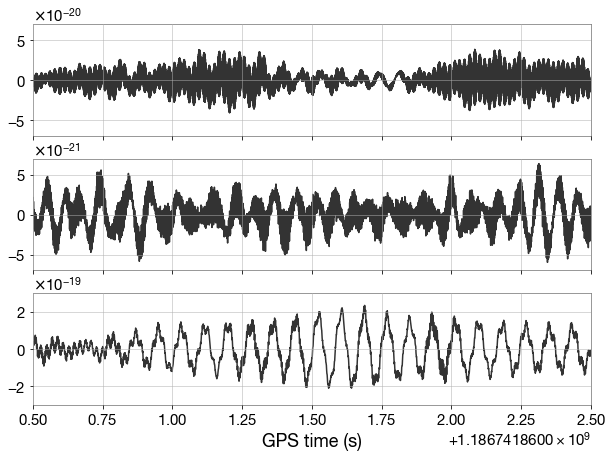

In [64]:
# Convert the data from gwpy to pyCBC format
strain_H1 = data_H1.to_pycbc()
strain_L1 = data_L1.to_pycbc()
strain_V1 = data_V1.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz
strain_H1 = highpass(strain_H1, 15.0)
strain_H1 = resample_to_delta_t(strain_H1, 1.0/2048)
strain_H1 = strain_H1.crop(2,2)

strain_L1 = highpass(strain_L1, 15.0)
strain_L1 = resample_to_delta_t(strain_L1, 1.0/2048)
strain_L1 = strain_L1.crop(2,2)

strain_V1 = highpass(strain_V1, 15.0)
strain_V1 = resample_to_delta_t(strain_V1, 1.0/2048)
strain_V1 = strain_V1.crop(2,2)


label = ['LIGO Hanford', 'LIGO Livingstone', 'VIRGO']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 7), sharex=True)
plt.rcParams.update({'font.size': 15})
ax1.plot(strain_H1.sample_times, strain_H1, color='black', alpha=0.8)
ax2.plot(strain_L1.sample_times, strain_L1, color='black', alpha=0.8)
ax3.plot(strain_V1.sample_times, strain_V1, color='black', alpha=0.8)
ax3.set_xlabel('GPS time (s)')
ax1.set_ylim(-7e-20,+7e-20)
ax2.set_ylim(-7e-21,+7e-21)
ax3.set_ylim(-3e-19,+3e-19)
plt.xlim(ev_gps-1, ev_gps+1)
plt.savefig(os.path.join(results_dir,'strain2.png'))
plt.show()

In [54]:
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd_H1 = strain_H1.psd(4)
psd_L1 = strain_L1.psd(4)
psd_V1 = strain_V1.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd_H1 = interpolate(psd_H1, strain_H1.delta_f)
psd_L1 = interpolate(psd_L1, strain_L1.delta_f)
psd_V1 = interpolate(psd_V1, strain_V1.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd_H1 = inverse_spectrum_truncation(psd_H1, int(4 * strain_H1.sample_rate), low_frequency_cutoff=15)
psd_L1 = inverse_spectrum_truncation(psd_L1, int(4 * strain_L1.sample_rate), low_frequency_cutoff=15)
psd_V1 = inverse_spectrum_truncation(psd_V1, int(4 * strain_V1.sample_rate), low_frequency_cutoff=15)

In [93]:
def match_filter(strain, psd, m_start, m_stop, dm, fig_title):

    m1_guess = np.arange(m_start, m_stop, dm)
    m2_guess = np.arange(m_start, m_stop, dm)
    
    m1_max_snr = 0
    m2_max_snr = 0
    max_snr_peak = 0

    for i in range (len(m1_guess)):
        for j in range(len(m2_guess)):
            hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=m1_guess[i], mass2=m2_guess[j],
                             delta_t=strain.delta_t, f_lower=20)

            # We will resize the vector to match our data
            hp.resize(len(strain))
            
            template = hp.cyclic_time_shift(hp.start_time)
            snr = matched_filter(template, strain, psd=psd, low_frequency_cutoff=20)
            snr = snr.crop(6, 6)
            #pylab.plot(snr.sample_times, abs(snr), color='red')
            #pylab.show()
            
            # Find the peak of snr
            peak = abs(snr).numpy().argmax()
            snrp = snr[peak]
            snr_peak = abs(snrp)
            
            # Control if the snr is higher than the one in the previous run
            if (snr_peak > max_snr_peak):
                max_snr_peak = snr_peak
                m1_max_snr = m1_guess[i]
                m2_max_snr = m2_guess[j]
    
    #Find snr and template for the best m1,m2
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=m1_max_snr, mass2=m2_max_snr, delta_t=strain.delta_t, f_lower=20)
    
    hp.resize(len(strain))
    template_best = hp.cyclic_time_shift(hp.start_time)
    snr_best = matched_filter(template_best, strain, psd=psd, low_frequency_cutoff=50)
    snr_best = snr_best.crop(6, 6) ###############
    pylab.figure(figsize=[12, 6])
    
    pylab.plot(snr_best.sample_times, abs(snr_best), color='black')
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time [s]')
    pylab.xlim(ev_gps-1, ev_gps+1)
    pylab.title(fig_title)
    pylab.rcParams.update({'font.size': 15})
    pylab.savefig(os.path.join(results_dir, 'snr'+'_'+fig_title.replace(" ", "_")+'.png'))
    pylab.show()
    
    peak = abs(snr_best).numpy().argmax()
    snrp = snr_best[peak]
    print(abs(snrp))
    time = snr_best.sample_times[peak]
    
    print("We find a signal at %lf s (%lf)" %(time, abs(snrp)))
    print("Maximum SNR peak = %lf \n corresponding to: m1 = %lf, m2 = %lf" %(max_snr_peak,m1_max_snr,m2_max_snr))

    return snr_best, template_best

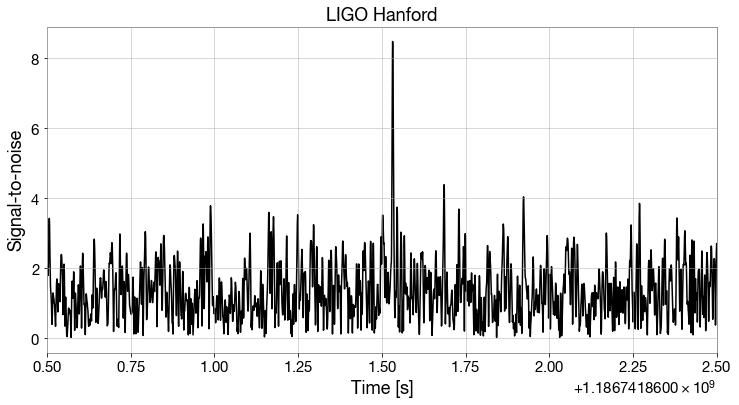

8.479140067169203
We find a signal at 1186741861.532227 s (8.479140)
Maximum SNR peak = 8.830451 
 corresponding to: m1 = 28.100000, m2 = 30.900000


In [94]:
snr_H1, template_H1 = match_filter(strain_H1, psd_H1, 20, 35, 0.1, 'LIGO Hanford')

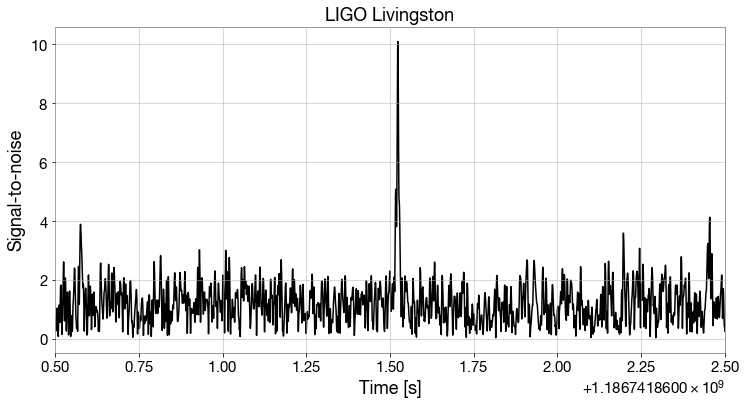

10.098055698914992
We find a signal at 1186741861.523438 s (10.098056)
Maximum SNR peak = 11.786973 
 corresponding to: m1 = 29.500000, m2 = 31.200000


In [57]:
snr_L1, template_L1 = match_filter(strain_L1, psd_L1, 20, 35, 0.1, 'LIGO Livingston')

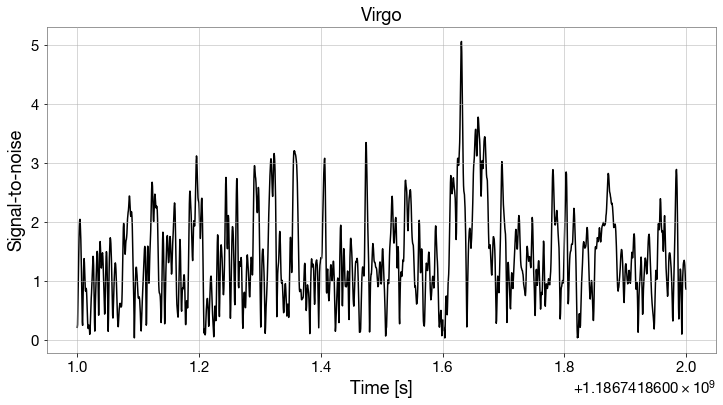

5.051928523531183
We find a signal at 1186741861.630859 s (5.051929)
Maximum SNR peak = 5.494953 
 corresponding to: m1 = 24.000000, m2 = 27.500000


In [91]:
snr_V1, template_V1 = match_filter(strain_V1, psd_V1, 20, 35, 0.5, 'Virgo')

In [83]:
ev_gps

1186741861.5

In [76]:
t_H = 1186741861.532227
t_L = 1186741861.523438
t_V = 1186741861.630859

In [81]:
np.sqrt((10**-5/t_H)**2 + (10**-5/t_L)**2)

1.191677489620541e-14

In [77]:
t_H - t_L

0.0087890625

In [82]:
t_V - t_L

0.1074209213256836

8.032226562


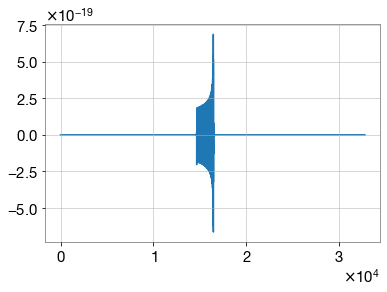

In [70]:
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

snr = snr_H1
template = template_H1
psd = psd_H1
strain = strain_H1

# Shift the template to the peak time
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
dt = time - strain.start_time
print(dt)
aligned = template.cyclic_time_shift(dt)
pylab.plot(aligned)

In [71]:
# Scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = strain.start_time

# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data

white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)

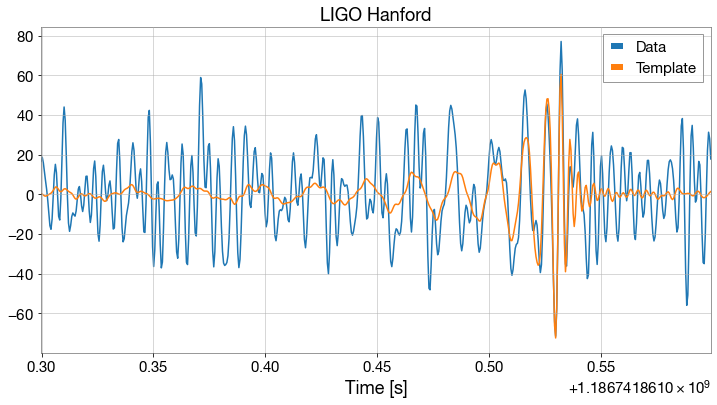

In [72]:
pylab.figure(figsize=[12, 6])
pylab.rcParams.update({'font.size': 15})
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
plt.xlim(min(white_data.sample_times), max(white_data.sample_times))
plt.xlabel('Time [s]')
pylab.legend()
pylab.title('LIGO Hanford') ##
pylab.savefig(os.path.join(results_dir, 'superposition_H.png')) ##
pylab.show()

/Users/margheritadetoma/opt/anaconda3/envs/labgw/lib/python3.8/site-packages/gwpy/plot/axes.py:293: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return super().pcolormesh(*args, **kwargs)


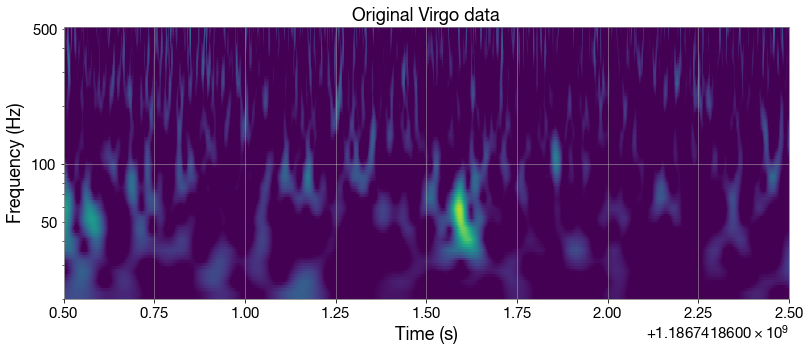

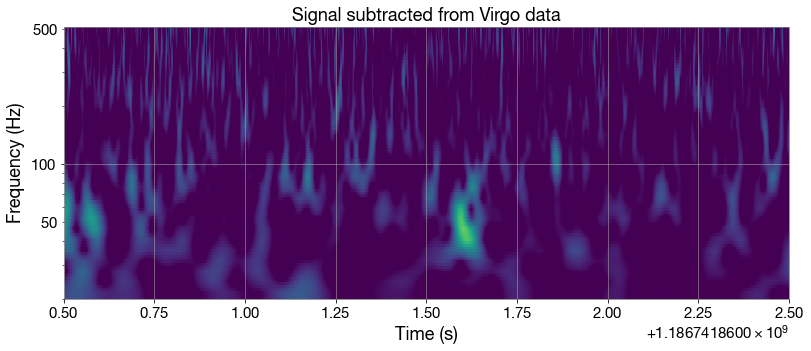

In [69]:
subtracted = strain - aligned

# Plot the original data and the subtracted signal data
C = 0
for data, title in [(strain, 'Original Virgo data'), ###
                    (subtracted, 'Signal subtracted from Virgo data')]: ###

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8),frange=(20, 512))
    pylab.rcParams.update({'font.size': 15})
    pylab.figure(figsize=[13, 5])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(ev_gps-1, ev_gps+1)
    if(C == 0):
        pylab.savefig(os.path.join(results_dir, 'spec_original_V.png'))
        C += 1
    pylab.savefig(os.path.join(results_dir, 'spec_whiten_V.png'))
    pylab.show()